In [117]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow.keras as keras 
from tensorflow.keras.models import Sequential 

from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
import random
import zipfile 
import os 

In [25]:
print(os.listdir(r'ml_notebooks\dogs-vs-cats'))

['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [27]:
with zipfile.ZipFile(r'ml_notebooks\dogs-vs-cats\test1.zip','r') as z:
    z.extractall('.')

In [28]:
with zipfile.ZipFile(r'ml_notebooks\dogs-vs-cats\train.zip','r') as z:
    z.extractall('.')

In [49]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Num GPUs Available: ", len(gpus))
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"GPU in use: {gpus[0]}")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU in use: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Training data preparation 

In [51]:
tr_data_filenames = os.listdir('./train')
categories = [] 

In [53]:
for filename in tr_data_filenames:
    category = 1 if 'dog' in filename else 0 
    categories.append(category)

In [54]:
df = pd.DataFrame({
    'filename': tr_data_filenames,
    'category': categories
})

In [57]:
df.head(5)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


<Axes: xlabel='category'>

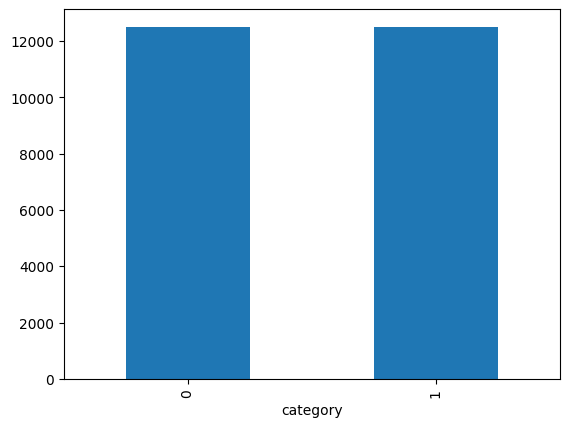

In [59]:
df['category'].value_counts().plot.bar()

The classes appear to be balanced based on the provided graph.  
Lets see image sample


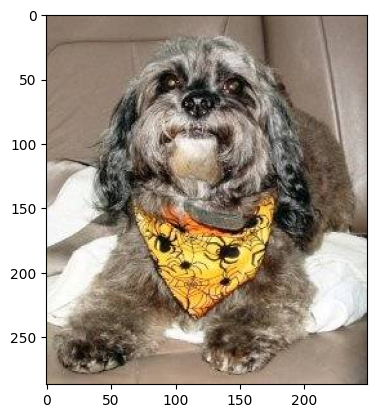

In [62]:
sample = random.choice(tr_data_filenames)
image = load_img('./train/'+sample)
plt.imshow(image)

In [64]:
df['category'] = df['category'].map({1:'dog', 0: 'cat'})

In [66]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


### Prepairing training & test data 

In [69]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

In [71]:
train_df, validate_df = train_test_split(df, test_size=0.1, shuffle=True)

In [73]:
train_df.reset_index(drop=True, inplace=True)
train_df

,filename,category
0,cat.10326.jpg,cat
1,cat.10885.jpg,cat
2,cat.676.jpg,cat
3,cat.8814.jpg,cat
4,dog.7452.jpg,dog
...,...,...
22495,dog.3361.jpg,dog
22496,dog.1222.jpg,dog
22497,cat.287.jpg,cat
22498,dog.10289.jpg,dog


In [75]:
validate_df.reset_index(drop=True, inplace=True)
validate_df

,filename,category
0,dog.5150.jpg,dog
1,cat.4380.jpg,cat
2,dog.11792.jpg,dog
3,dog.185.jpg,dog
4,cat.5086.jpg,cat
...,...,...
2495,dog.9021.jpg,dog
2496,cat.10224.jpg,cat
2497,cat.4731.jpg,cat
2498,cat.3827.jpg,cat


## ImageDataGenerator 

for train data 

In [79]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    rescale=1./255, 
    shear_range = 0.1,
    zoom_range = 0.2, 
    horizontal_flip = True,
    width_shift_range = 0.1, 
    height_shift_range = 0.1
)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory = "./train",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = IMAGE_SIZE, 
    batch_size = 16
)

Found 22500 validated image filenames belonging to 2 classes.


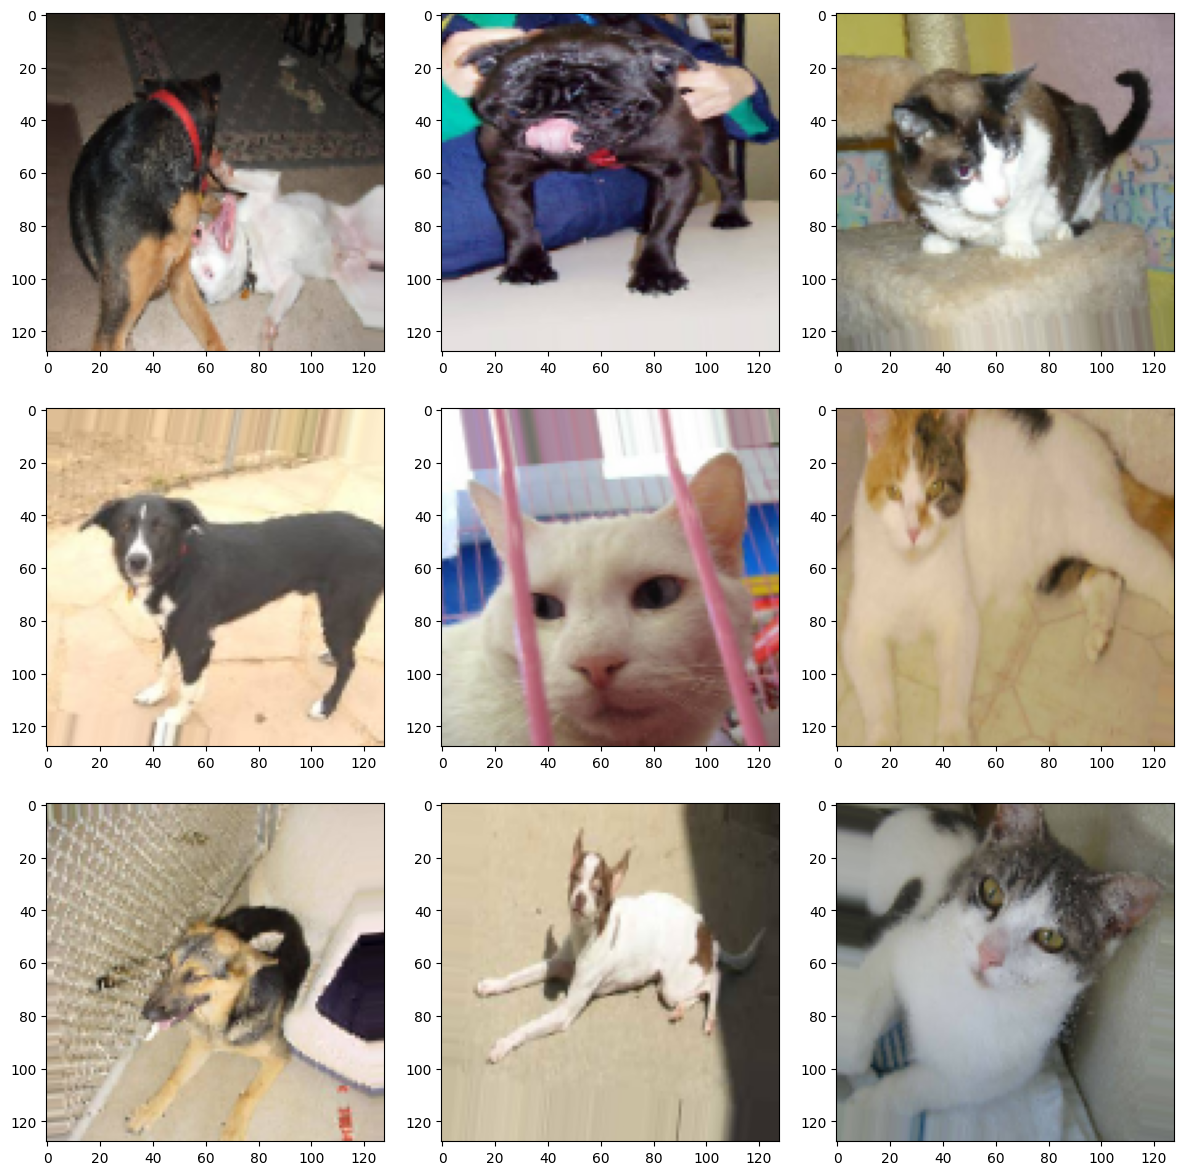

In [80]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_gen:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

for validation data 

In [82]:
val_datagen = ImageDataGenerator(
    rescale=1./255, 
)
val_gen = train_datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory = "./train",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = IMAGE_SIZE, 
    batch_size = 16
)

Found 2500 validated image filenames belonging to 2 classes.


## Model building 

In [84]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

### Callbacks

In [122]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

## Fitting the model

In [126]:
history = model.fit(
    train_gen,
    epochs =30,
    validation_data=val_gen,
    callbacks = [early_stoping,learning_rate_reduction],
    validation_steps = validate_df.shape[0]//16,
    steps_per_epoch = train_df.shape[0]//16
)

Epoch 1/30
1406/1406 [==============================] - 321s 228ms/step - loss: 0.3774 - accuracy: 0.8281 - val_loss: 0.3760 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - 241s 171ms/step - loss: 0.3662 - accuracy: 0.8353 - val_loss: 0.5004 - val_accuracy: 0.7901 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.8360
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1406/1406 [==============================] - 252s 179ms/step - loss: 0.3651 - accuracy: 0.8360 - val_loss: 1.8133 - val_accuracy: 0.5212 - lr: 0.0010
Epoch 4/30
1406/1406 [==============================] - 208s 148ms/step - loss: 0.3430 - accuracy: 0.8472 - val_loss: 0.2907 - val_accuracy: 0.8822 - lr: 5.0000e-04
Epoch 5/30
1406/1406 [==============================] - 207s 147ms/step - loss: 0.3248 - accuracy: 0.8557 - val_loss: 0.3326 - val_accuracy: 0.8594 - lr: 5.0000e-04
Epoch 6/30
1406/1406 [==

### Training Validation

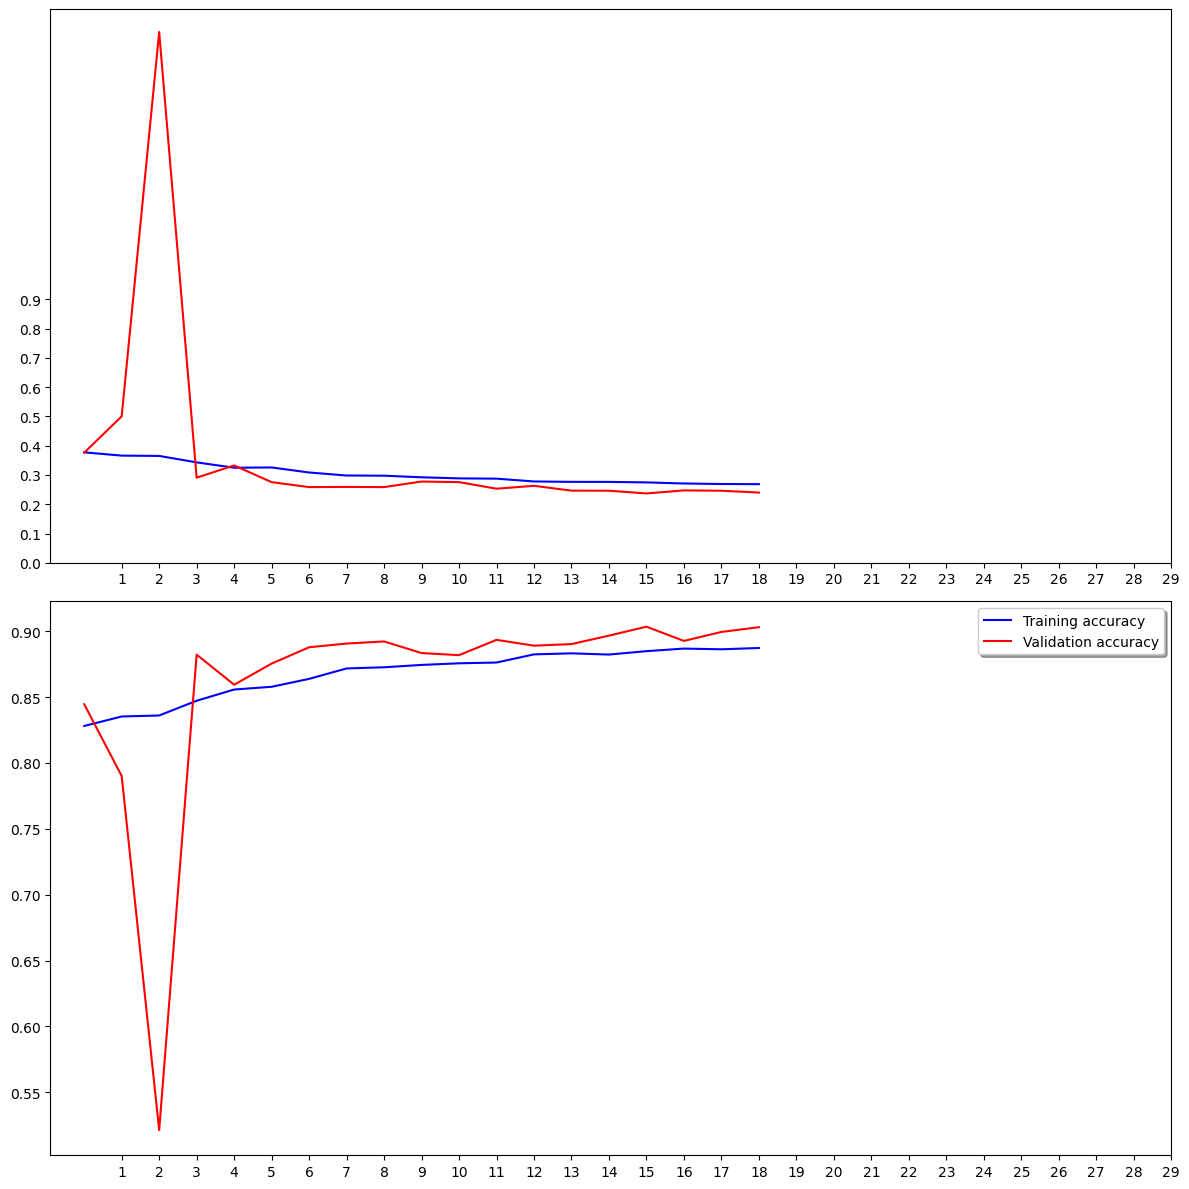

In [130]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [172]:
Y_val = validate_df['category'].map({'cat':0, 'dog':1})
y_pred =  model.predict(val_gen)

157/157 [==============================] - 29s 187ms/step


In [174]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [176]:
y_final

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [1]])

In [178]:
Y_val

0       1
1       0
2       1
3       1
4       0
       ..
2495    1
2496    0
2497    0
2498    0
2499    1
Name: category, Length: 2500, dtype: int64

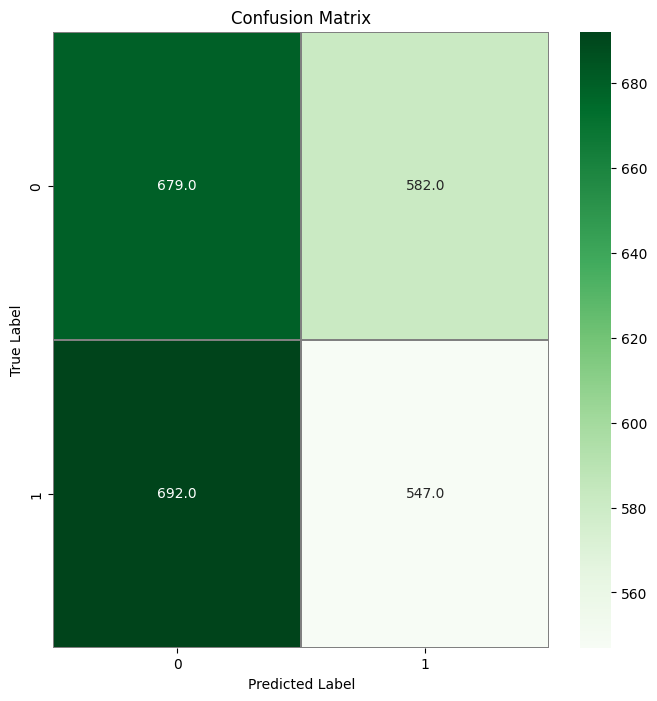

In [180]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [182]:
from sklearn.metrics import classification_report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)


              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1261
           1       0.48      0.44      0.46      1239

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



### Testing data preparation

In [188]:
test_data_filenames = os.listdir("./test1")
test_df = pd.DataFrame({
    'filename':test_data_filenames
})

### Testing Generator 

In [197]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=16,
    target_size = IMAGE_SIZE,
    shuffle=False
)


Found 12500 validated image filenames.


### Predictions 

In [202]:
predict = model.predict(test_generator, 
                        steps=np.ceil(test_df.shape[0]/16)
                       )

782/782 [==============================] - 231s 296ms/step


In [204]:
test_df['category'] = np.where(predict > threshold, 1,0)

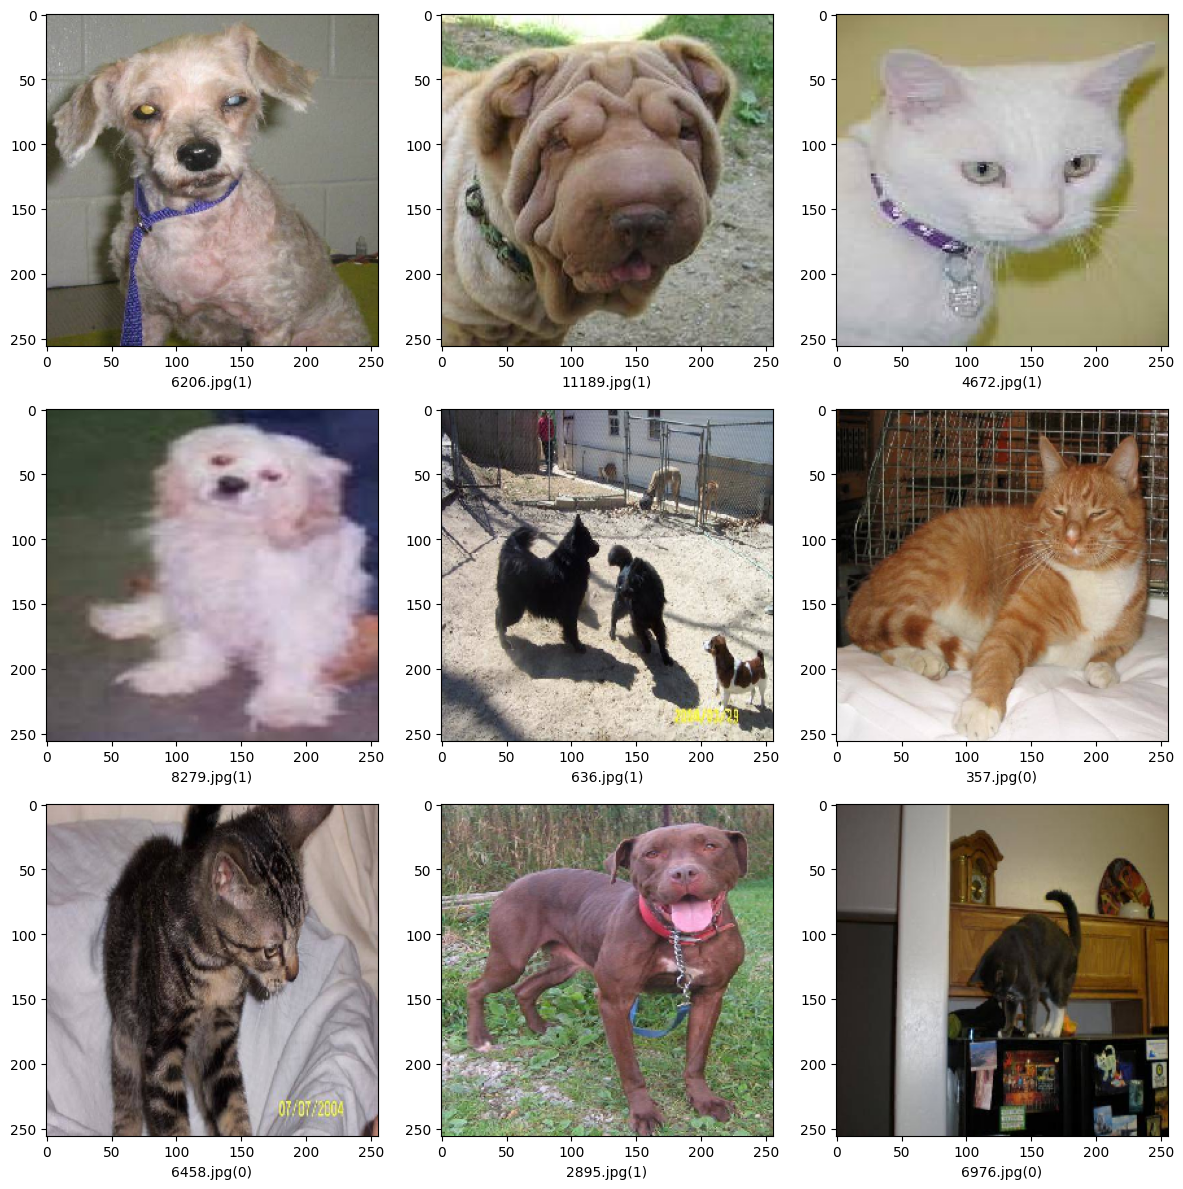

In [208]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [210]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)